## Price and analyse datapoints not used for calibration.

#### 1. Price out-of-sample European swaptions and analyse errors.

In [4]:
import pandas as pd
import re
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from src.ZeroRateCurve import ExampleNSSCurve
from src.HullWhite import OneFactorHullWhiteModel
from src.Swaption import EuropeanSwaption, SwaptionType
from src.HullWhiteTreeSwaptionPricer import HullWhiteTreeEuropeanSwaptionPricer

# === Calibrated parameters (from calibration run) ===
# a was fixed to 0.003 during calibration
# Calibrated sigmas: [0.01063532 0.00925409 0.00999584 0.01053541 0.01070387 0.01122338 0.01145982
#  0.01192899 0.01229241 0.01203773 0.01174515 0.01388203]
# Residual norm: 0.15778219416380734
CALIBRATED_A = 0.003
CALIBRATED_SIGMAS = np.array([
    0.01063532, 0.00925409, 0.00999584, 0.01053541, 0.01070387, 0.01122338, 0.01145982,
    0.01192899, 0.01229241, 0.01203773, 0.01174515, 0.01388203
])

# === Global settings ===
ZCB_CURVE = ExampleNSSCurve()
TIMESTEP = 1/48
MAX_WORKERS = 12

# === Helper functions ===
def extract_tenors(description):
    matches = re.findall(r'(\d+)([YM])', description.upper())
    tenors = []
    for amount, unit in matches:
        amount = float(amount)
        if unit == 'M':
            amount /= 12
        tenors.append(amount)

    if tenors[0] < 0.5: # ignore short expiry for now.
        print(f"Ignoring short expiry in description {description}...'")
        return None, None
    if len(tenors) >= 2:
        return tenors[0], tenors[1]
    elif len(tenors) == 1:
        return tenors[0], None
    else:
        return None, None

def price_swaption(hw_model, swap_start, swap_end, timestep):
    swaption = EuropeanSwaption(
        swaption_type=SwaptionType.PAYER,
        swap_start=swap_start,
        swap_end=swap_end,
        payment_frequency=0.5,
    )
    tree = swaption.build_valuation_tree(ZCB_CURVE, set_ATM_strike=True, 
                                         model=hw_model, timestep=timestep, verbose=False)
    return HullWhiteTreeEuropeanSwaptionPricer.price_in_bps(swaption, tree)

# === Load all available data ===
df_all = pd.read_csv("./data/swaption_quotes_ALL.csv")
df_calibration = pd.read_csv("./data/swaption_quotes_CALIBRATION.csv")
df_all = df_all.dropna()
df_all = df_all[df_all['Description'].str.contains("EUR Swaption Premium", na=False)]

# drop the ones used for calibration!
df_all = df_all[~df_all['Description'].isin(df_calibration['Description'])]

# === Initialize model ===
model = OneFactorHullWhiteModel(CALIBRATED_A)
model.set_sigmas_from_vector(CALIBRATED_SIGMAS)

# === Parallel pricing ===
def price_row(row):
    # print(f"Pricing row index {row.Index}: {row.Description}...")
    swap_start, swap_dur = extract_tenors(row.Description)
    if swap_start is None or swap_dur is None:
        return np.nan
    swap_end = swap_start + swap_dur
    return price_swaption(model, swap_start, swap_end, TIMESTEP)

prices = [0.0] * len(df_all)
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {executor.submit(price_row, row): i for i, row in enumerate(df_all.itertuples())}
    for future in as_completed(futures):
        idx = futures[future]
        try:
            prices[idx] = future.result()
        except Exception as e:
            print(f"Pricing failed at index {idx}: {e}")
            prices[idx] = np.nan

df_all["Model_Premium"] = prices
df_all.dropna(inplace=True) # drop rows where pricing failed
print(f"Priced {len(df_all)} swaptions successfully.")

df_all["Abs_Error_bps"] = np.abs(df_all["Model_Premium"] - df_all["Quoted_Premium"])
df_all["Rel_Error_pct"] = 100.0 * (df_all["Model_Premium"] - df_all["Quoted_Premium"]) / df_all["Quoted_Premium"]

# === Compute metrics ===
mae = np.nanmean(df_all["Abs_Error_bps"])
rmse = np.sqrt(np.nanmean((df_all["Model_Premium"] - df_all["Quoted_Premium"]) ** 2))
mre = np.nanmean(np.abs(df_all["Rel_Error_pct"]))

print("\n===== VALIDATION RESULTS =====")
print(f"Mean Absolute Error (bps): {mae:.4f}")
print(f"Root Mean Squared Error (bps): {rmse:.4f}")
print(f"Mean Relative Error (pct): {mre:.4f}%")

# === Save results ===
df_all.to_csv("./results/swaption_validation_results.csv", index=False)
print("\nDetailed results saved to ./results/swaption_validation_results.csv")


Ignoring short expiry in description EUR Swaption Premium 3M10Y...'
Ignoring short expiry in description EUR Swaption Premium 1M10Y...'
Ignoring short expiry in description EUR Swaption Premium 3M5Y...'
Ignoring short expiry in description EUR Swaption Premium 1M20Y...'
Ignoring short expiry in description EUR Swaption Premium 2M15Y...'
Ignoring short expiry in description EUR Swaption Premium 3M30Y...'


/home/roger/Documents/HullWhite/src/VectorizedHullWhiteTrinomialTree.py:224: RuntimeWarning: divide by zero encountered in log
  a           = np.log(Q) - short_rates[layer_mask] * delta_t


Ignoring short expiry in description EUR Swaption Premium 1M15Y...'
Ignoring short expiry in description EUR Swaption Premium 1M2Y...'
Ignoring short expiry in description EUR Swaption Premium 1M25Y...'
Ignoring short expiry in description EUR Swaption Premium 1M3Y...'
Ignoring short expiry in description EUR Swaption Premium 1M30Y...'
Ignoring short expiry in description EUR Swaption Premium 1M4Y...'
Ignoring short expiry in description EUR Swaption Premium 1M5Y...'
Ignoring short expiry in description EUR Swaption Premium 1M6Y...'
Ignoring short expiry in description EUR Swaption Premium 1M7Y...'
Ignoring short expiry in description EUR Swaption Premium 1M8Y...'
Ignoring short expiry in description EUR Swaption Premium 1M9Y...'
Ignoring short expiry in description EUR Swaption Premium 2M10Y...'
Ignoring short expiry in description EUR Swaption Premium 2M2Y...'
Ignoring short expiry in description EUR Swaption Premium 2M20Y...'
Ignoring short expiry in description EUR Swaption Premium

OUTPUT:
```
...
Root Mean Squared Error (bps): 17.5670
Mean Relative Error (pct): 1.4953%

Detailed results saved to ./results/swaption_validation_results.csv
```

#### 2. Visualize errors.

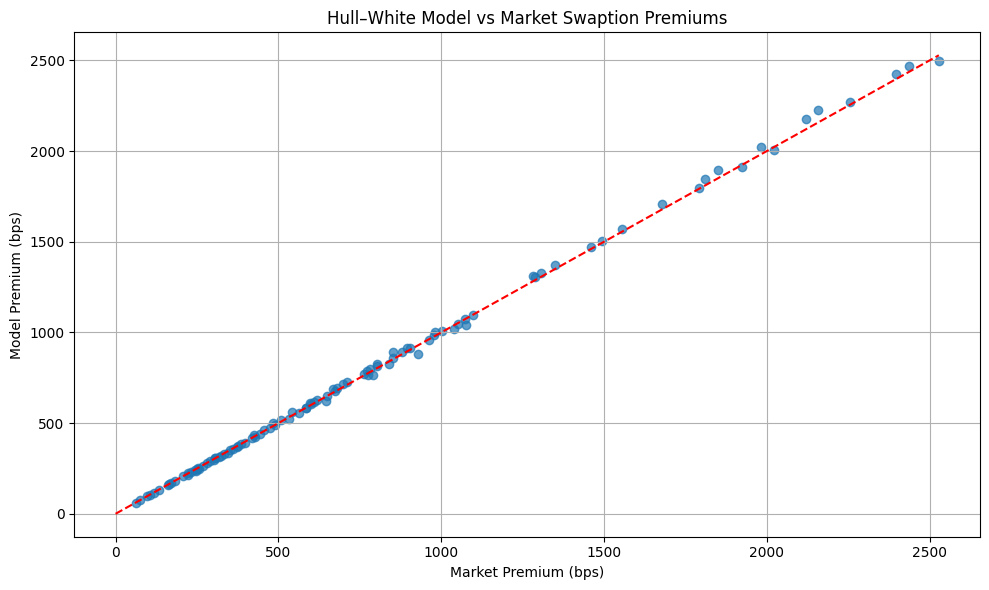

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(df_all["Quoted_Premium"], df_all["Model_Premium"], alpha=0.7)
plt.plot([0, max(df_all["Quoted_Premium"])],
         [0, max(df_all["Quoted_Premium"])], 'r--')
plt.xlabel("Market Premium (bps)")
plt.ylabel("Model Premium (bps)")
plt.title("Hull–White Model vs Market Swaption Premiums")
plt.grid(True)
plt.tight_layout()
plt.show()


It is clear visually that long dated swaptions usually produce more error, which makes sense for a variety of intuition.

#### 3. Plotting residual heatmap.

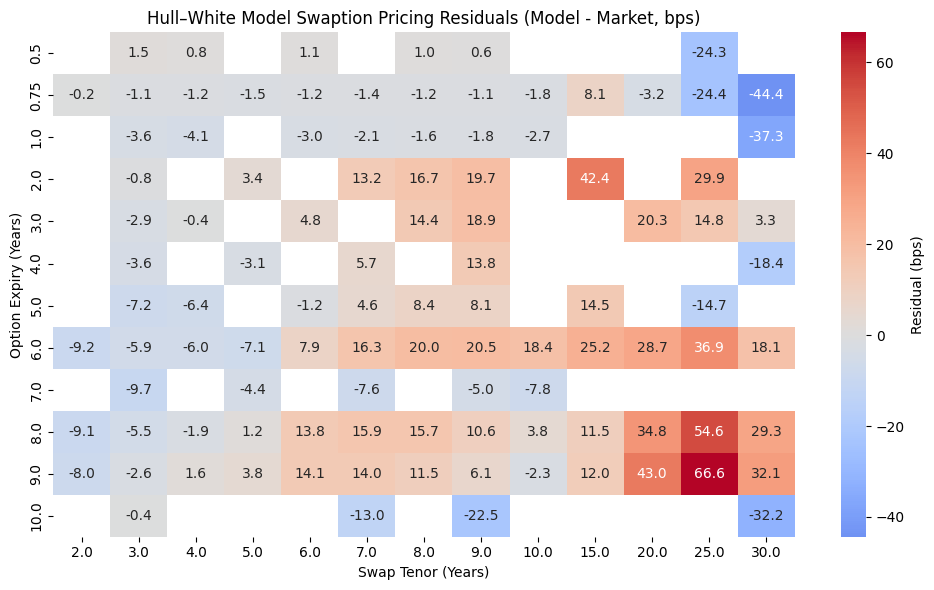

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# --- Extract expiry & tenor from description ---
def extract_tenors(description):
    matches = re.findall(r'(\d+)([YM])', description.upper())
    tenors = []
    for amount, unit in matches:
        amount = float(amount)
        if unit == 'M':
            amount /= 12
        tenors.append(amount)
    if len(tenors) >= 2:
        return tenors[0], tenors[1]
    elif len(tenors) == 1:
        return tenors[0], None
    else:
        return None, None

# --- Compute residuals ---
df_all["Expiry"], df_all["Tenor"] = zip(*df_all["Description"].map(extract_tenors))
df_all["Residual (bps)"] = df_all["Model_Premium"] - df_all["Quoted_Premium"]

# --- Pivot table for heatmap ---
heatmap_data = df_all.pivot_table(
    index="Expiry", columns="Tenor", values="Residual (bps)", aggfunc="mean"
).sort_index(ascending=True)

# --- Plot ---
plt.figure(figsize=(10,6))
sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".1f",
    cbar_kws={'label': 'Residual (bps)'}
)
plt.title("Hull–White Model Swaption Pricing Residuals (Model - Market, bps)")
plt.xlabel("Swap Tenor (Years)")
plt.ylabel("Option Expiry (Years)")
plt.tight_layout()
plt.show()


Higher the swap tenor, the larger the error. Higher the option expiry, the larger the error, combinitorially, maybe.

A lot of growing overestimation between tenor 6-25, for some reason.

Maybe the "breakpoints" for the model's volatility function could be reconsidered?

#### 4. Plotting the calibrated implied volatility structure.

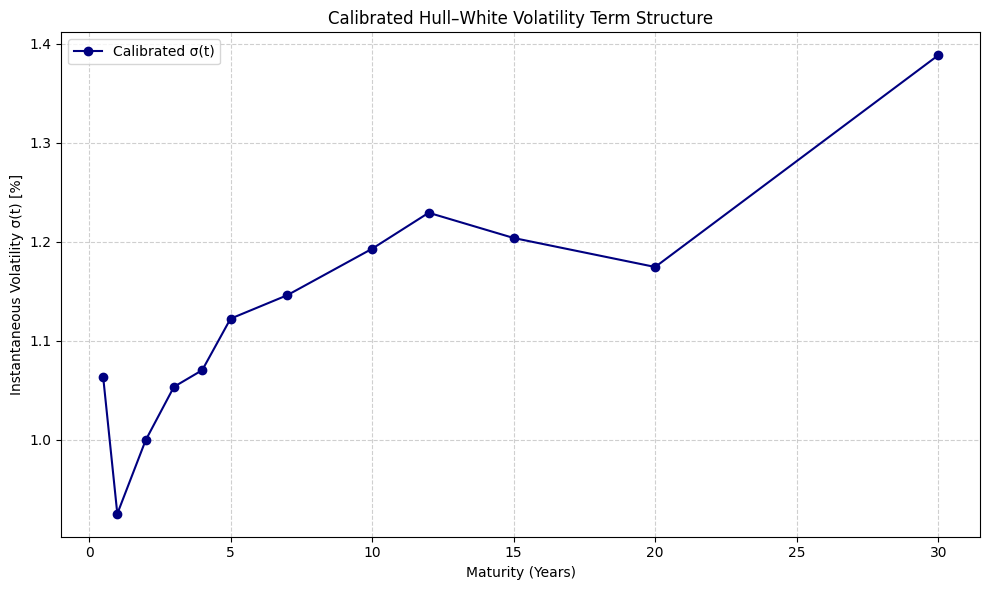

In [8]:
import matplotlib.pyplot as plt
import numpy as np

SIGMA_BREAKPOINTS = [0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 30]

plt.figure(figsize=(10,6))
plt.plot(SIGMA_BREAKPOINTS, CALIBRATED_SIGMAS * 100, marker='o', linestyle='-', color='navy', label='Calibrated σ(t)')
plt.xlabel("Maturity (Years)")
plt.ylabel("Instantaneous Volatility σ(t) [%]")
plt.title("Calibrated Hull–White Volatility Term Structure")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


The instantaneous volatility has an overall positively increasing trend, which makes intuitive sense.

The instantaneous volatility at t=0.5 is somehow very high? Perhaps it's expected for how the interest rate moves. Perhaps something happened in the market around 09/28/2025? Or perhaps it's simply due to lack of datapoints for the shortest maturity?




## Final Results: Deriving the Implied Volatility Term Structure

In [ ]:
# ------------------------------
# Compute IV *at breakpoints only*
# ------------------------------
breakpoints = model.sigma_breakpoints
iv_at_breaks = [model.implied_vol(T) * 100 for T in breakpoints]  # to %

# ------------------------------
# Print Table
# ------------------------------
print("Implied Volatility at Breakpoints")
print("---------------------------------")
for T, iv in zip(breakpoints, iv_at_breaks):
    print(f"Maturity: {T:>5} yrs | IV: {iv:6.3f}%")
print("---------------------------------\n")

# ------------------------------
# Plot IV at Breakpoints Only
# ------------------------------
plt.figure(figsize=(10,6))
plt.plot(breakpoints, iv_at_breaks, marker='o', linestyle='-', color='darkred', label="IV at breakpoints")

plt.xlabel("Maturity (Years)")
plt.ylabel("Implied Volatility [%]")
plt.title("Hull–White Implied Volatility at Breakpoints")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()